# Sharpe-Based Momentum Strategy with Risk Parity

This notebook implements and analyzes a momentum strategy using 12-month Sharpe ratio ranking with risk parity allocation and monthly rebalancing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from momentum_strategy import run_full_strategy
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data and Run Strategy

In [2]:
# Run the complete momentum strategy
results = run_full_strategy(data_dir='data', lookback_months=12, top_quantile=0.25)

# Extract results
prices = results['prices']
monthly_returns = results['monthly_returns']
momentum_signals = results['momentum_signals']
weights = results['weights']
portfolio_returns = results['portfolio_returns']
portfolio_cumulative = results['portfolio_cumulative']
metrics = results['metrics']

print(f"Sharpe-based momentum strategy with risk parity covers {len(portfolio_returns.dropna())} months")
print(f"Portfolio data from {portfolio_returns.dropna().index[0].strftime('%Y-%m')} to {portfolio_returns.dropna().index[-1].strftime('%Y-%m')}")
print(f"Selection criteria: Top 25% by 12-month Sharpe ratio")
print(f"Allocation method: Risk parity (inverse volatility weighting)")

Loading data...
Calculating monthly returns...
Calculating momentum signals...
Selecting top performers...
Running backtest...
Calculating performance metrics...
Sharpe-based momentum strategy with risk parity covers 308 months
Portfolio data from 2000-01 to 2025-08
Selection criteria: Top 25% by 12-month Sharpe ratio
Allocation method: Risk parity (inverse volatility weighting)


## Data Availability Timeline

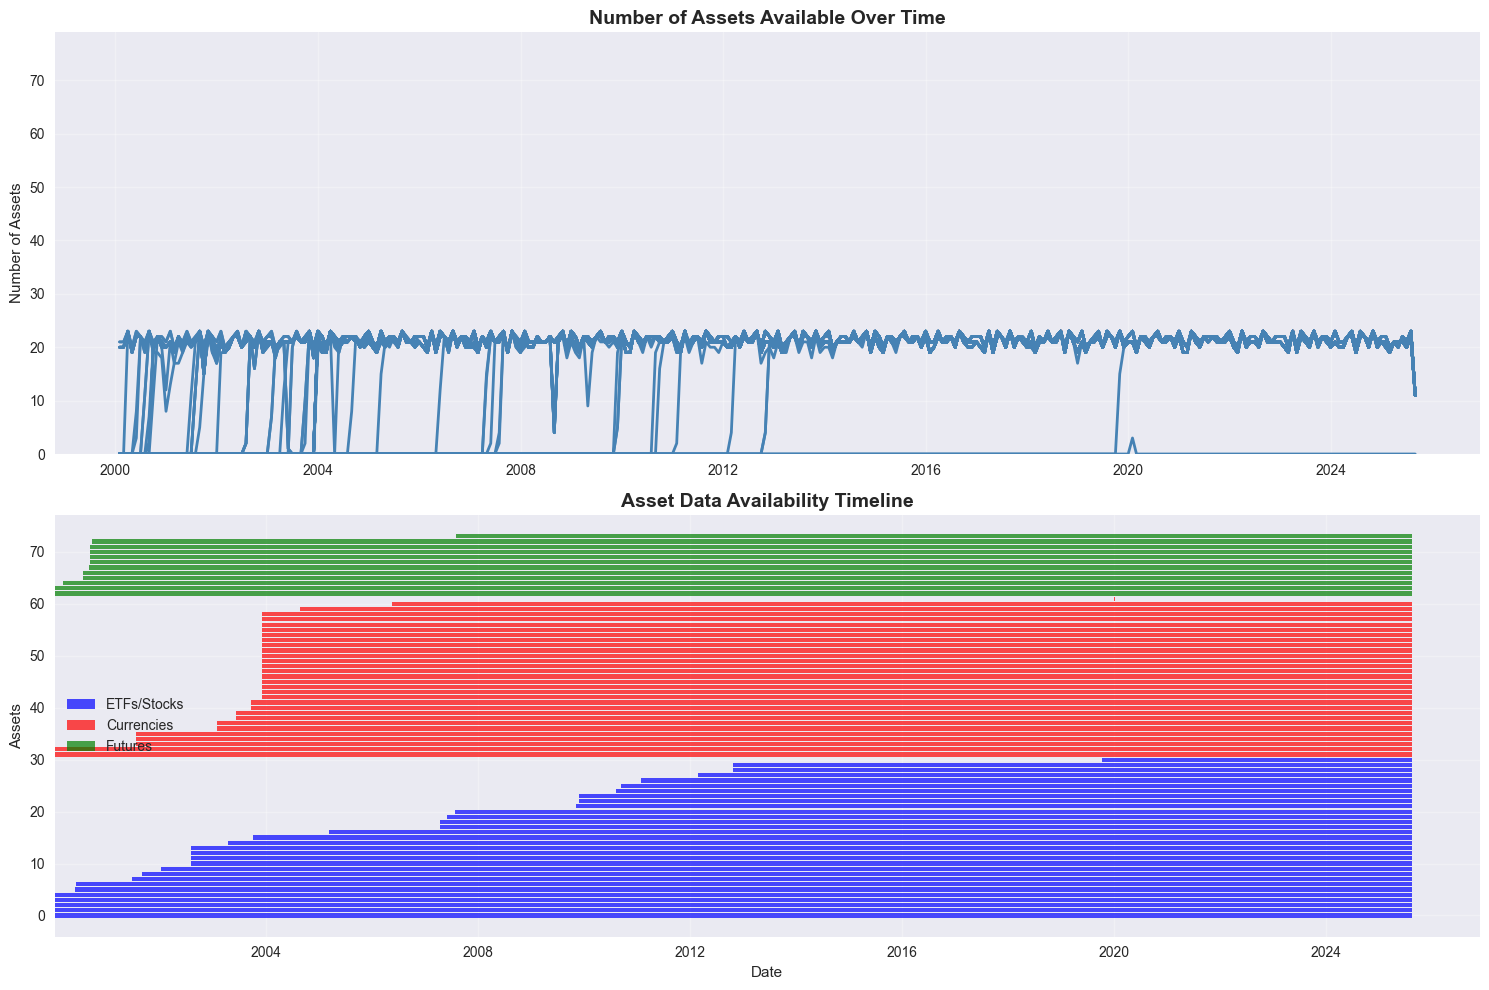

Total assets: 74
Assets by category:
  ETFs/Stocks: 31
  Currencies: 31
  Futures: 12


In [3]:
# Create data availability heatmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Data availability over time
data_availability = (~prices.isnull()).astype(int)
data_coverage = data_availability.resample('Y').mean()

# Plot 1: Number of assets available over time
assets_available = data_availability.resample('M').sum()
ax1.plot(assets_available.index, assets_available, linewidth=2, color='steelblue')
ax1.set_title('Number of Assets Available Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Assets')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, len(prices.columns) + 5)

# Plot 2: Asset inception timeline
first_dates = prices.apply(lambda x: x.first_valid_index()).sort_values()
asset_categories = {
    'ETFs/Stocks': [col for col in first_dates.index if not ('_X' in col or '_F' in col)],
    'Currencies': [col for col in first_dates.index if '_X' in col],
    'Futures': [col for col in first_dates.index if '_F' in col]
}

colors = {'ETFs/Stocks': 'blue', 'Currencies': 'red', 'Futures': 'green'}
y_pos = 0

for category, assets in asset_categories.items():
    for asset in assets:
        start_date = first_dates[asset]
        end_date = prices[asset].last_valid_index()
        ax2.barh(y_pos, (end_date - start_date).days, left=start_date, 
                height=0.8, color=colors[category], alpha=0.7, label=category if y_pos == 0 or category != prev_category else "")
        prev_category = category
        y_pos += 1

ax2.set_title('Asset Data Availability Timeline', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Assets')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total assets: {len(prices.columns)}")
print(f"Assets by category:")
for category, assets in asset_categories.items():
    print(f"  {category}: {len(assets)}")

## Strategy Performance Analysis

In [4]:
# Display performance metrics
print("=" * 70)
print("SHARPE-BASED MOMENTUM + RISK PARITY PERFORMANCE METRICS")
print("=" * 70)

for key, value in metrics.items():
    if isinstance(value, float):
        if 'Return' in key or 'Excess' in key:
            print(f"{key:<25}: {value:.2%}")
        elif 'Ratio' in key:
            print(f"{key:<25}: {value:.3f}")
        elif 'Drawdown' in key:
            print(f"{key:<25}: {value:.2%}")
        elif 'Volatility' in key:
            print(f"{key:<25}: {value:.2%}")
        elif 'Months' in key:
            print(f"{key:<25}: {value:.1%}")
        else:
            print(f"{key:<25}: {value:.4f}")
    else:
        print(f"{key:<25}: {value}")

SHARPE-BASED MOMENTUM + RISK PARITY PERFORMANCE METRICS
Total Return             : 172.77%
Annualized Return        : 3.99%
Volatility               : 5.40%
Sharpe Ratio             : 0.738
Max Drawdown             : -10.41%
Positive Months          : 63.3%
Average Monthly Return   : 0.34%
Best Month               : 0.0703
Worst Month              : -0.0592
Benchmark Total Return   : 627.71%
Benchmark Annualized Return: 8.07%
Benchmark Volatility     : 15.21%
Benchmark Sharpe         : 0.5304
Benchmark Max Drawdown   : -50.78%
Excess Return            : -4.87%
Information Ratio        : -0.337


## Equity Curve Visualization

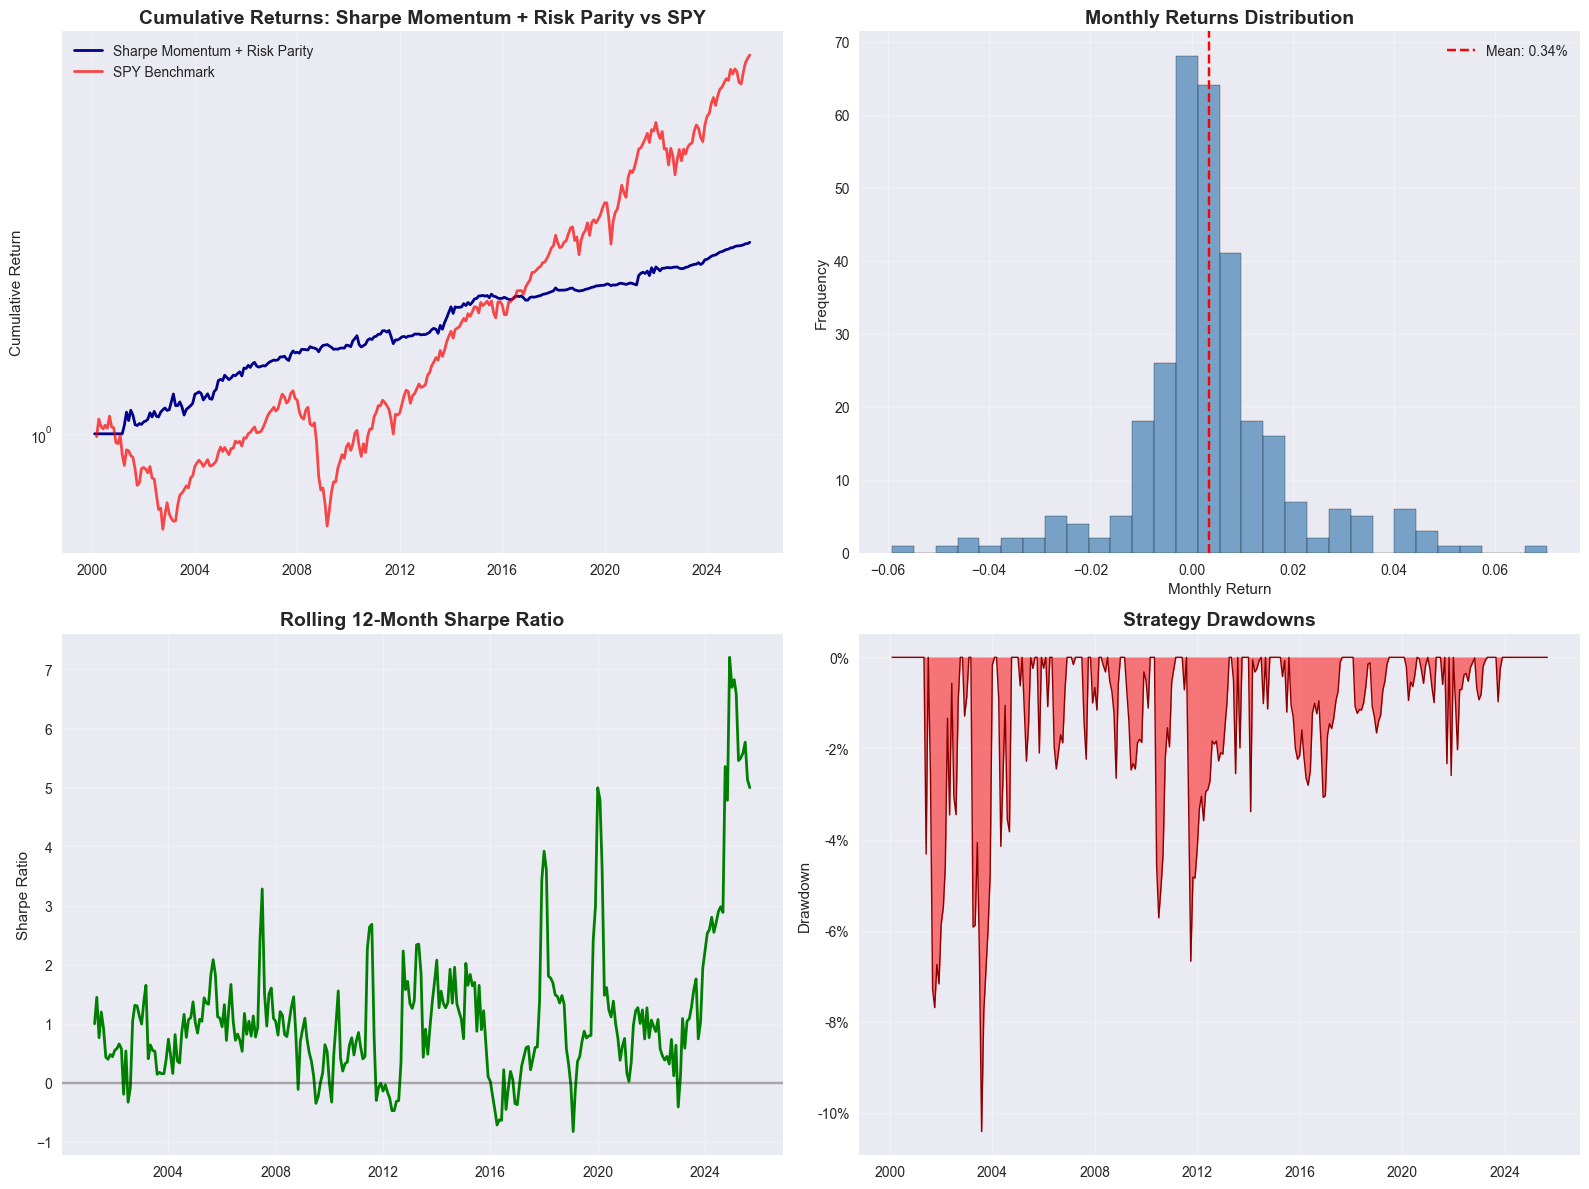

In [5]:
# Plot equity curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Cumulative returns comparison
portfolio_clean = portfolio_cumulative.dropna()
ax1.plot(portfolio_clean.index, portfolio_clean, linewidth=2, label='Sharpe Momentum + Risk Parity', color='darkblue')

if 'SPY' in monthly_returns.columns:
    spy_returns = monthly_returns['SPY'].dropna()
    spy_cumulative = (1 + spy_returns).cumprod()
    # Align dates
    common_dates = portfolio_clean.index.intersection(spy_cumulative.index)
    if len(common_dates) > 0:
        ax1.plot(common_dates, spy_cumulative.reindex(common_dates), 
                linewidth=2, label='SPY Benchmark', color='red', alpha=0.7)

ax1.set_title('Cumulative Returns: Sharpe Momentum + Risk Parity vs SPY', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Monthly returns distribution
portfolio_returns_clean = portfolio_returns.dropna()
ax2.hist(portfolio_returns_clean, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(portfolio_returns_clean.mean(), color='red', linestyle='--', 
           label=f'Mean: {portfolio_returns_clean.mean():.2%}')
ax2.set_title('Monthly Returns Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Monthly Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe ratio (12-month)
rolling_sharpe = portfolio_returns_clean.rolling(12).apply(
    lambda x: x.mean() / x.std() * np.sqrt(12) if x.std() > 0 else np.nan
)
ax3.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='green')
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.set_title('Rolling 12-Month Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio')
ax3.grid(True, alpha=0.3)

# Plot 4: Drawdown analysis
cumulative = (1 + portfolio_returns_clean).cumprod()
running_max = cumulative.expanding().max()
drawdowns = (cumulative - running_max) / running_max

ax4.fill_between(drawdowns.index, drawdowns, 0, alpha=0.5, color='red')
ax4.plot(drawdowns.index, drawdowns, linewidth=1, color='darkred')
ax4.set_title('Strategy Drawdowns', fontsize=14, fontweight='bold')
ax4.set_ylabel('Drawdown')
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

## Monthly Returns Heatmap

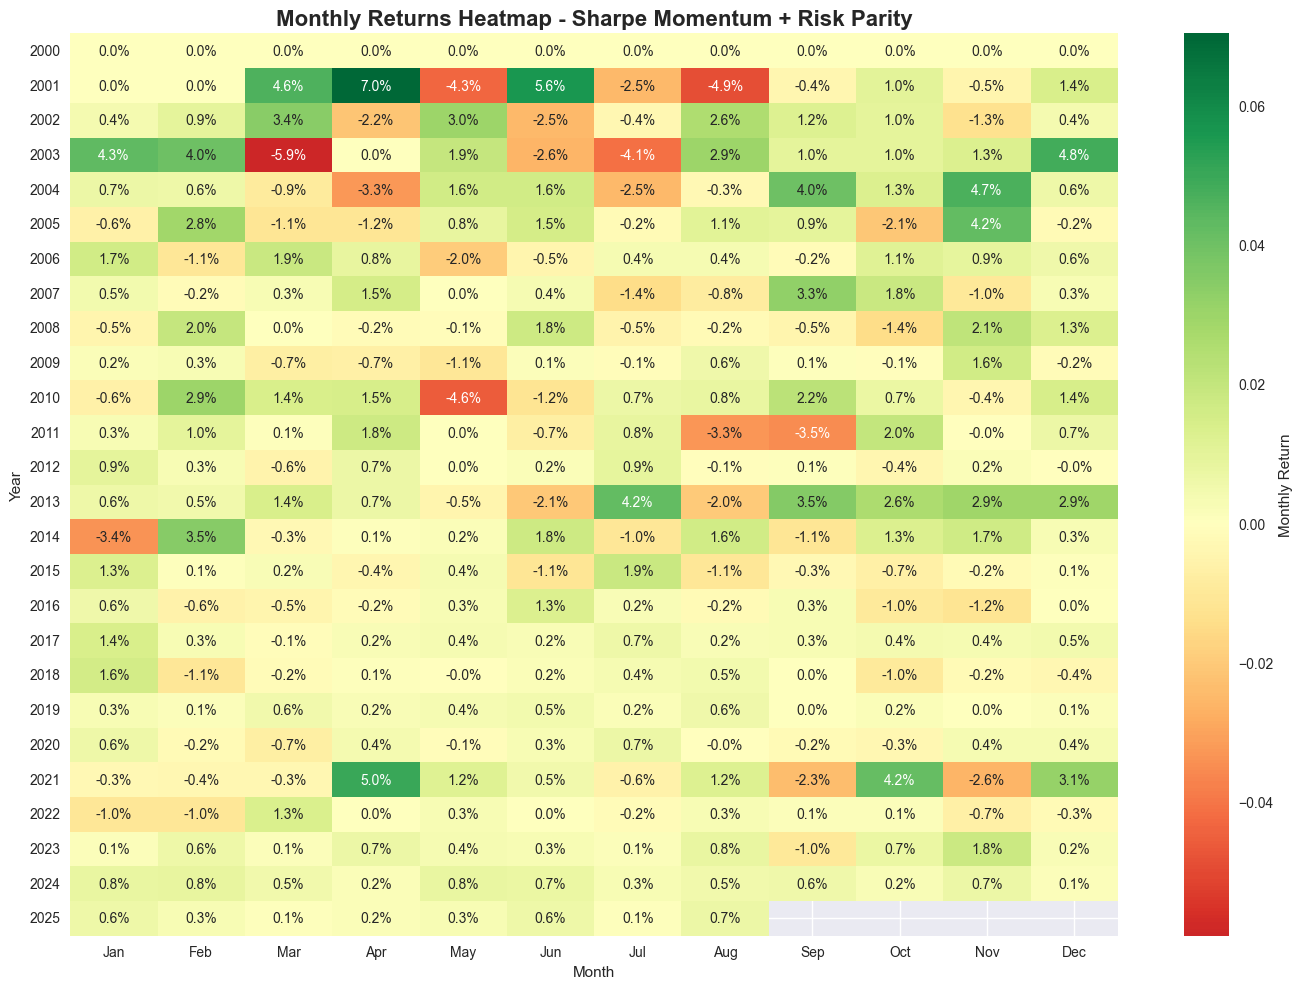


ANNUAL RETURNS:
------------------------------
2000: 0.00%
2001: 6.50%
2002: 6.57%
2003: 8.35%
2004: 8.16%
2005: 5.86%
2006: 4.01%
2007: 4.70%
2008: 3.64%
2009: -0.06%
2010: 4.68%
2011: -0.99%
2012: 2.18%
2013: 15.67%
2014: 4.50%
2015: 0.03%
2016: -0.90%
2017: 4.95%
2018: -0.13%
2019: 3.20%
2020: 1.12%
2021: 8.79%
2022: -0.93%
2023: 5.01%
2024: 6.30%
2025: 2.86%


In [6]:
# Create monthly returns heatmap
portfolio_returns_clean = portfolio_returns.dropna()
monthly_data = portfolio_returns_clean.to_frame('Returns')
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month

# Create pivot table for heatmap
heatmap_data = monthly_data.pivot_table(values='Returns', index='Year', columns='Month')

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.1%', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Monthly Return'}, 
            xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Returns Heatmap - Sharpe Momentum + Risk Parity', fontsize=16, fontweight='bold')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# Calculate annual returns
annual_returns = monthly_data.groupby('Year')['Returns'].apply(lambda x: (1 + x).prod() - 1)
print("\nANNUAL RETURNS:")
print("-" * 30)
for year, ret in annual_returns.items():
    print(f"{year}: {ret:.2%}")

## Risk Parity Allocation Analysis

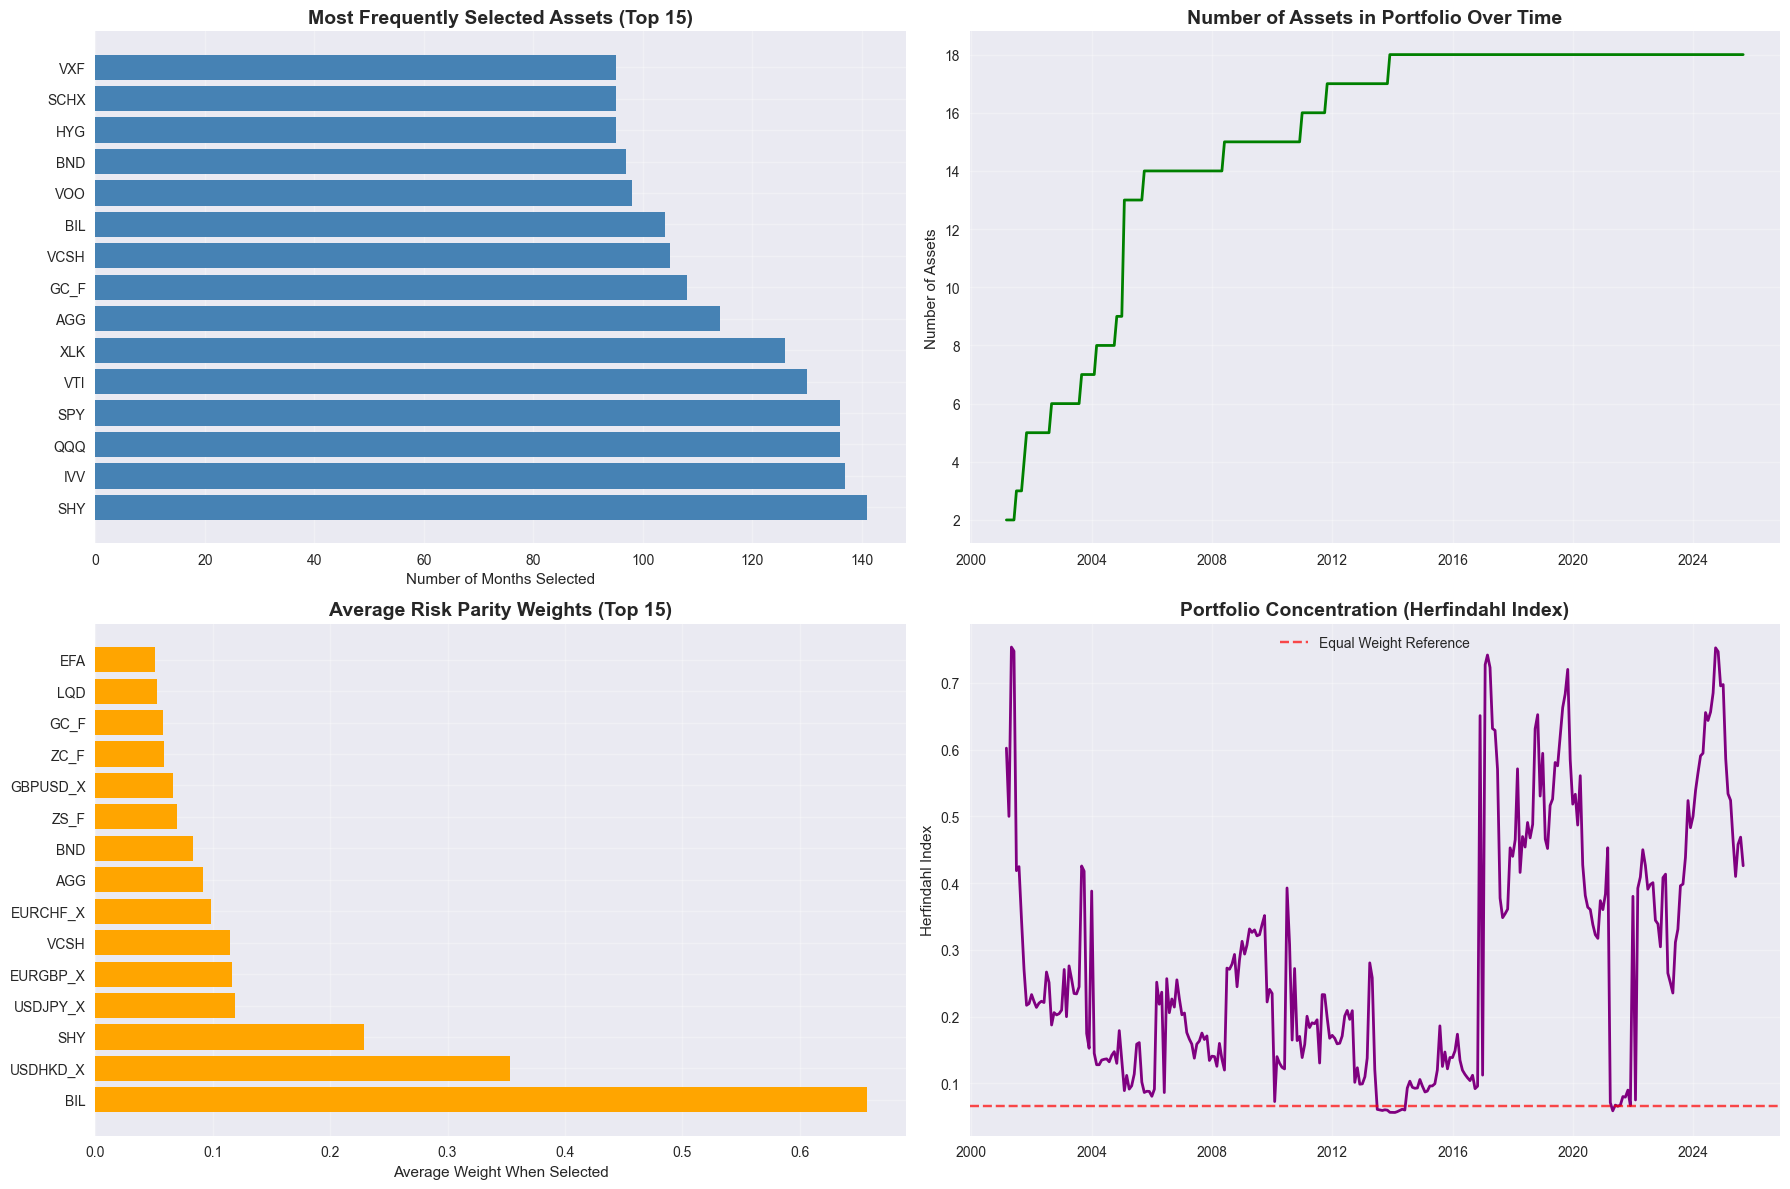


RISK PARITY PORTFOLIO STATISTICS:
Average number of assets held: 15.0
Min assets held: 2
Max assets held: 18
Average Herfindahl index: 0.2817
Total months analyzed: 295


In [7]:
# Analyze risk parity weights over time
weights_clean = weights.loc[weights.sum(axis=1) > 0]

# Count frequency of each asset being selected
selection_frequency = (weights_clean > 0).sum().sort_values(ascending=False)
top_selected = selection_frequency.head(15)

# Calculate average weights for selected assets
avg_weights = weights_clean[weights_clean > 0].mean().sort_values(ascending=False).head(15)

# Plot analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Most frequently selected assets
ax1.barh(range(len(top_selected)), top_selected.values, color='steelblue')
ax1.set_yticks(range(len(top_selected)))
ax1.set_yticklabels(top_selected.index)
ax1.set_xlabel('Number of Months Selected')
ax1.set_title('Most Frequently Selected Assets (Top 15)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Portfolio concentration over time
portfolio_concentration = weights_clean.apply(lambda row: (row > 0).sum(), axis=1)
ax2.plot(portfolio_concentration.index, portfolio_concentration, linewidth=2, color='green')
ax2.set_title('Number of Assets in Portfolio Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Assets')
ax2.grid(True, alpha=0.3)

# Plot 3: Average risk parity weights
ax3.barh(range(len(avg_weights)), avg_weights.values, color='orange')
ax3.set_yticks(range(len(avg_weights)))
ax3.set_yticklabels(avg_weights.index)
ax3.set_xlabel('Average Weight When Selected')
ax3.set_title('Average Risk Parity Weights (Top 15)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Weight concentration (Herfindahl index)
herfindahl = weights_clean.apply(lambda row: (row**2).sum(), axis=1)
ax4.plot(herfindahl.index, herfindahl, linewidth=2, color='purple')
ax4.set_title('Portfolio Concentration (Herfindahl Index)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Herfindahl Index')
ax4.grid(True, alpha=0.3)
equal_weight_line = 1 / portfolio_concentration.mean()
ax4.axhline(equal_weight_line, color='red', linestyle='--', alpha=0.7, label=f'Equal Weight Reference')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nRISK PARITY PORTFOLIO STATISTICS:")
print(f"Average number of assets held: {portfolio_concentration.mean():.1f}")
print(f"Min assets held: {portfolio_concentration.min()}")
print(f"Max assets held: {portfolio_concentration.max()}")
print(f"Average Herfindahl index: {herfindahl.mean():.4f}")
print(f"Total months analyzed: {len(weights_clean)}")

## Risk Contribution Analysis

Calculating risk contributions...


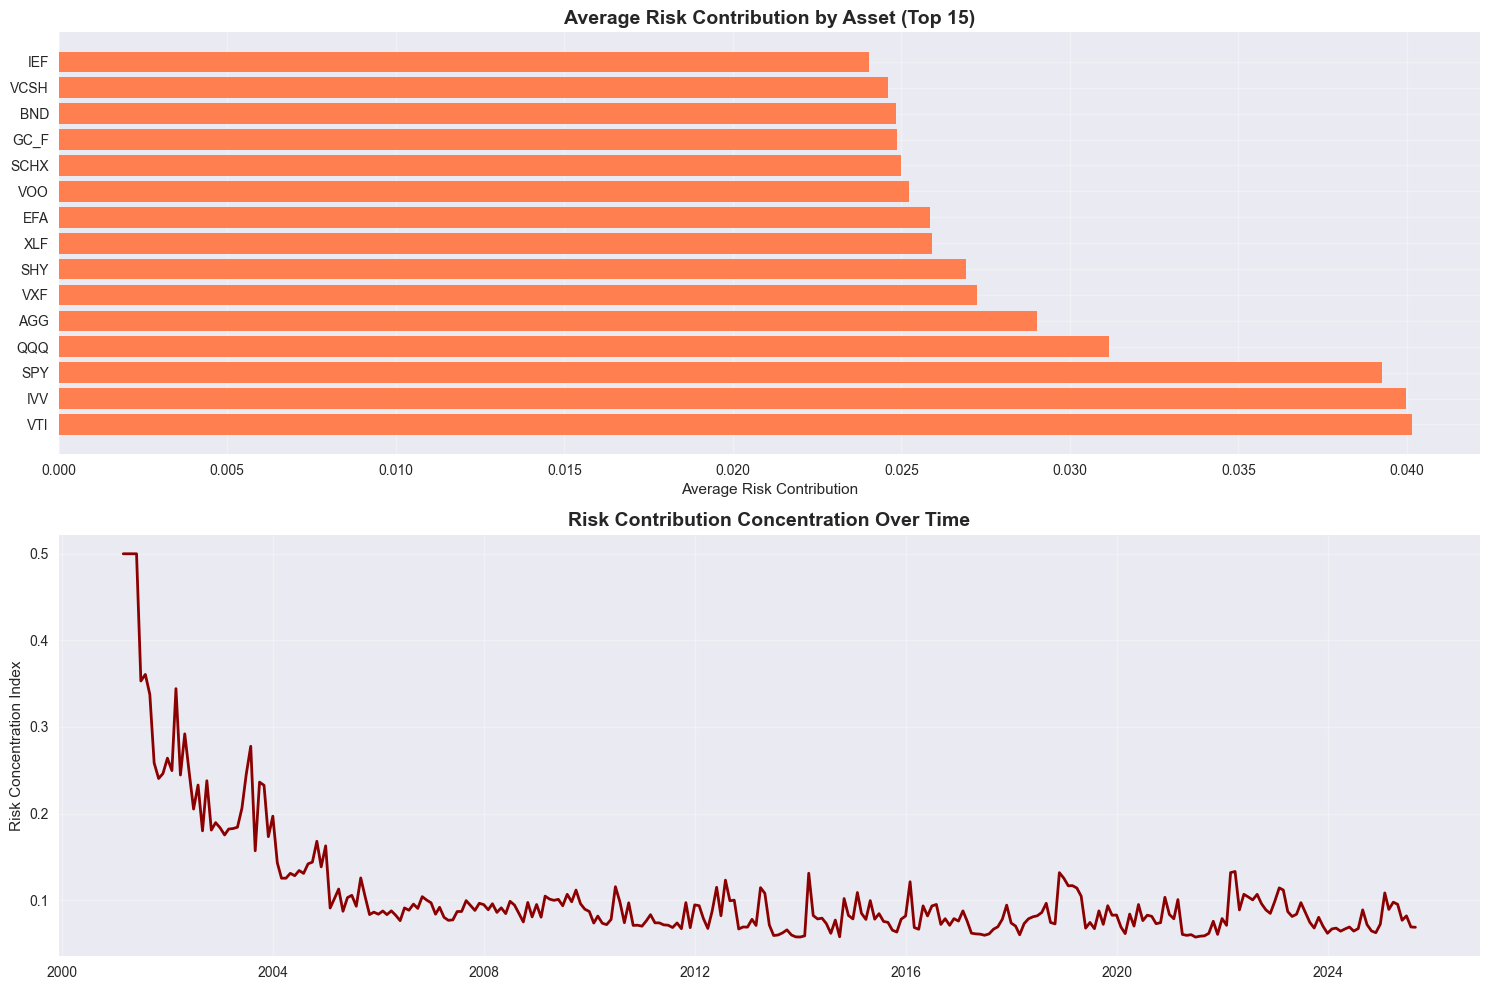


RISK CONTRIBUTION ANALYSIS:
Average risk concentration: 0.1075
Risk parity effectiveness: 89.2%


In [8]:
# Analyze risk contributions over time
def calculate_risk_contributions(weights, returns, lookback=12):
    """Calculate risk contributions for portfolio holdings."""
    risk_contribs = []
    
    for date in weights.index:
        if weights.loc[date].sum() > 0:
            # Get portfolio weights
            w = weights.loc[date][weights.loc[date] > 0]
            
            # Get historical returns for calculation period
            end_idx = returns.index.get_loc(date)
            start_idx = max(0, end_idx - lookback)
            hist_returns = returns.iloc[start_idx:end_idx+1][w.index]
            
            if len(hist_returns) > 1:
                # Calculate covariance matrix
                cov_matrix = hist_returns.cov() * 12  # Annualized
                
                # Calculate portfolio variance
                portfolio_var = w.T @ cov_matrix @ w
                
                # Calculate marginal risk contributions
                if portfolio_var > 0:
                    marginal_contrib = cov_matrix @ w
                    risk_contrib = w * marginal_contrib / portfolio_var
                    
                    risk_contribs.append(pd.Series(risk_contrib, name=date))
    
    if risk_contribs:
        return pd.DataFrame(risk_contribs).fillna(0)
    else:
        return pd.DataFrame()

# Calculate risk contributions
print("Calculating risk contributions...")
risk_contributions = calculate_risk_contributions(weights_clean, monthly_returns)

if not risk_contributions.empty:
    # Plot risk contribution evolution
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Average risk contribution by asset
    avg_risk_contrib = risk_contributions.mean().sort_values(ascending=False).head(15)
    ax1.barh(range(len(avg_risk_contrib)), avg_risk_contrib.values, color='coral')
    ax1.set_yticks(range(len(avg_risk_contrib)))
    ax1.set_yticklabels(avg_risk_contrib.index)
    ax1.set_xlabel('Average Risk Contribution')
    ax1.set_title('Average Risk Contribution by Asset (Top 15)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Risk contribution concentration over time
    risk_concentration = risk_contributions.apply(lambda row: (row**2).sum(), axis=1)
    ax2.plot(risk_concentration.index, risk_concentration, linewidth=2, color='darkred')
    ax2.set_title('Risk Contribution Concentration Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Risk Concentration Index')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nRISK CONTRIBUTION ANALYSIS:")
    print(f"Average risk concentration: {risk_concentration.mean():.4f}")
    print(f"Risk parity effectiveness: {(1 - risk_concentration.mean()) * 100:.1f}%")
else:
    print("Could not calculate risk contributions - insufficient data")

## Summary Statistics

In [9]:
# Final summary table
print("=" * 80)
print("SHARPE-BASED MOMENTUM + RISK PARITY STRATEGY SUMMARY")
print("=" * 80)
print(f"Strategy Period: {portfolio_returns.dropna().index[0].strftime('%B %Y')} to {portfolio_returns.dropna().index[-1].strftime('%B %Y')}")
print(f"Total Months: {len(portfolio_returns.dropna())}")
print(f"Selection Metric: 12-month Sharpe ratio")
print(f"Top Quantile: 25%")
print(f"Allocation Method: Risk parity (inverse volatility)")
print(f"Rebalancing: Monthly")
print(f"Universe Size: {len(prices.columns)} assets")
print()
print("KEY PERFORMANCE METRICS:")
print(f"Total Return: {metrics['Total Return']:.2%}")
print(f"Annualized Return: {metrics['Annualized Return']:.2%}")
print(f"Volatility: {metrics['Volatility']:.2%}")
print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
print(f"Maximum Drawdown: {metrics['Max Drawdown']:.2%}")
print(f"Positive Months: {metrics['Positive Months']:.1%}")

if 'Benchmark Total Return' in metrics:
    print()
    print("vs SPY BENCHMARK:")
    print(f"Excess Return: {metrics['Excess Return']:.2%}")
    print(f"Information Ratio: {metrics['Information Ratio']:.3f}")

print()
print("STRATEGY FEATURES:")
print("✓ Sharpe ratio-based momentum (risk-adjusted returns)")
print("✓ Risk parity allocation (inverse volatility weighting)")
print("✓ No look-ahead bias (proper signal shifting)")
print("✓ Monthly rebalancing with 12-month lookback")
print("✓ Multi-asset universe (equities, bonds, currencies, commodities)")

SHARPE-BASED MOMENTUM + RISK PARITY STRATEGY SUMMARY
Strategy Period: January 2000 to August 2025
Total Months: 308
Selection Metric: 12-month Sharpe ratio
Top Quantile: 25%
Allocation Method: Risk parity (inverse volatility)
Rebalancing: Monthly
Universe Size: 74 assets

KEY PERFORMANCE METRICS:
Total Return: 172.77%
Annualized Return: 3.99%
Volatility: 5.40%
Sharpe Ratio: 0.738
Maximum Drawdown: -10.41%
Positive Months: 63.3%

vs SPY BENCHMARK:
Excess Return: -4.87%
Information Ratio: -0.337

STRATEGY FEATURES:
✓ Sharpe ratio-based momentum (risk-adjusted returns)
✓ Risk parity allocation (inverse volatility weighting)
✓ No look-ahead bias (proper signal shifting)
✓ Monthly rebalancing with 12-month lookback
✓ Multi-asset universe (equities, bonds, currencies, commodities)
